## Problem 8.1: A hierarchical model for cell viability on biomaterials

In [6]:
import itertools

import numpy as np
import pandas as pd
import altair as alt
import altair_catplot as altcat

import bebi103

import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()
color_palette=['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f', '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

Loading BokehJS ...

**a)** First we will do some exploratory data analysis to investigate the data set.

Let's first read in the data set and look at how it's organized.

In [7]:
df = pd.read_csv('../data/shao_et_al_wst-1_assay.csv')

# Take a look
df.head()

Treatment Experiment  assay_result
0   Control        One       1.45945
1   Control        One       1.51035
2   Control        One       1.80045
3   Control        One       1.83745
4     PLA_1        One       1.42015

It looks like there are 5 groups, control, PLA_1, PLA_2, PLA_3, and Neg_ctrl. In each experiment, they measured cell viability, and they did three experiments for each group.

Let's plot the cell viabliity by group and color by experiment to look at where the values are.

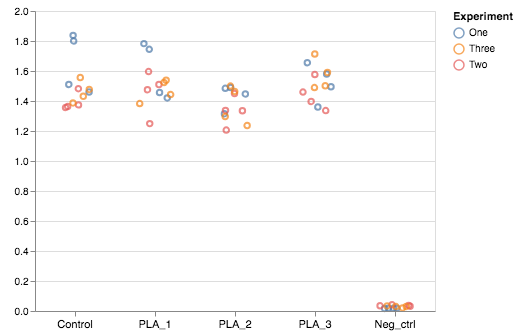

In [8]:
altcat.catplot(data=df,
               mark='point',
               encoding=dict(y=alt.Y('assay_result:Q', title=None),
                             x='Treatment:N', 
                             color=alt.Color('Experiment:N')),
               transform='jitter'
              )

For the control group, the cell viability is around 1.3 to 1.9. For the negative control, the cell viability values are all around 0.01 to 0.04. For the PLA groups, the cell viability values range from 1.2 to 1.8.

**b)** We'd like to construct a hierarchical model describing the results. For the control, we assume the typical assay value for a viable group of cells is around unity, and we choose a gaussian as our prior. For the PLA groups, we will also choose a gaussian for our prior and make sure to encompass the possibility of all the cells dying as well as thriving. **We will use the same prior for the control and PLA groups because.....** For the negative control, we assume that the typical baseline (absence of viable cells) does not go much beyond 0.05. We will use a half normal distribution as our prior for the negative control.

Let's do a prior predictive check for the negative control. 

In [17]:
model_code_pri_pred_neg = """
data {
  // Total number of data points
  int N;
  int J_1;
  real hyper_theta_mu;
  real hyper_theta_sigma;
  real hyper_sigma;
  real hyper_tau;
}


generated quantities {
  real n[N * J_1];
  real theta = fabs(normal_rng(hyper_theta_mu, hyper_theta_sigma));
  real sigma = fabs(normal_rng(0, hyper_sigma));
  real tau = fabs(normal_rng(0, hyper_tau));
  real theta_1[J_1];  
  
  for (i in 1:J_1) {
    theta_1[i] = fabs(normal_rng(theta, sigma));
    for (j in 1:N) {
      n[(i - 1) * N + j] = fabs(normal_rng(theta_1[i], tau));
    }
  }
    
  }
"""

In [18]:
# Complie from the standalone file
sm_gen = bebi103.stan.StanModel(model_code=model_code_pri_pred_neg)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c04b180d7be1179aa60f851d595dfa6c NOW.
/Users/madelynw/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/cn/x4zmqr494ln7sfp5z2kytzqw0000gp/T/tmpksb705vx/stanfit4anon_model_c04b180d7be1179aa60f851d595dfa6c_5418811267503343101.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [26]:
N_iter = 1000

data = dict(N=4,
            J_1=3,
            hyper_theta_mu=0.05,
            hyper_theta_sigma=0.3,
            hyper_sigma=0.1,
            hyper_tau=0.1)

# Sample
df_pred = sm_gen.sampling(data=data,
                     algorithm='Fixed_param',
                     warmup=0,
                     chains=1,
                     iter=N_iter)

df_samples = bebi103.stan.extract_array(df_pred, name='n')

# Plot
bokeh.io.show(
    bebi103.viz.predictive_ecdf(df_pred, 
                                'n', 
                                x_axis_label='assay_result'))

Is this ok?

Just as a sanity check...

In [27]:
num_neg, _ = df_samples.loc[df_samples['n'] < 0].shape

num_neg / N_iter

0.0

Let's do a prior predictive check for the control. 

In [28]:
model_code_pri_pred = """
data {
  // Total number of data points
  int N;
  int J_1;
  real hyper_theta_mu;
  real hyper_theta_sigma;
  real hyper_sigma;
  real hyper_tau;
}


generated quantities {
  real n[N * J_1];
  real theta = normal_rng(hyper_theta_mu, hyper_theta_sigma);
  real sigma = fabs(normal_rng(0, hyper_sigma));
  real tau = fabs(normal_rng(0, hyper_tau));
  real theta_1[J_1];  
  
  for (i in 1:J_1) {
    theta_1[i] = normal_rng(theta, sigma);
    for (j in 1:N) {
      n[(i - 1) * N + j] = normal_rng(theta_1[i], tau);
    }
  }
    
  }
"""

Compile the stan code from the standalone file.

In [29]:
# Complie from the standalone file
sm_gen = bebi103.stan.StanModel(model_code=model_code_pri_pred)

Using cached StanModel.


Sample and plot results.

In [30]:
N_iter = 1000

data = dict(N=4,
            J_1=3,
            hyper_theta_mu=1.,
            hyper_theta_sigma=0.3,
            hyper_sigma=0.1,
            hyper_tau=0.1)

# Sample
df_pred = sm_gen.sampling(data=data,
                     algorithm='Fixed_param',
                     warmup=0,
                     chains=1,
                     iter=N_iter)

df_samples = bebi103.stan.extract_array(df_pred, name='n')

# Plot
bokeh.io.show(
    bebi103.viz.predictive_ecdf(df_pred, 
                                'n', 
                                x_axis_label='assay_result'))

This looks reasonable for the control. We have some negative values so let's check what fraction of values are negative.

In [31]:
num_neg, _ = df_samples.loc[df_samples['n'] < 0].shape

num_neg / N_iter

0.024

About 3% of the sampled values are negative, which is small enough that we're willing to accept. Let's move on to coding up our model with these priors. 

In [32]:
model_code_centered = """
data {
  // Total number of data points
  int N;
  
  // Number of entries in each level of the hierarchy
  int J_1;

  //Index arrays to keep track of hierarchical structure
  int index_1[N];
  
  // The measurements
  real assay_result[N];
}


parameters {
  // Hyperparameters level 0
  real theta;
  real<lower=0> sigma;

  // How hyperparameters vary
  real<lower=0> tau;

  // Hyperparameters level 1
  vector[J_1] theta_1;
}


model {
  theta ~ normal(1, 0.3);
  sigma ~ normal(0, 0.1);
  tau ~ normal(0, 0.1);

  theta_1 ~ normal(theta, tau);

  assay_result ~ normal(theta_1[index_1], sigma);
}
"""

In [33]:
data, df_part = bebi103.stan.df_to_datadict_hier(df.loc[df['Treatment']=='Control'],
                                           level_cols=['Experiment'],
                                           data_cols='assay_result')

data

{'N': 12,
 'J_1': 3,
 'index_1': array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]),
 'assay_result': array([1.45945, 1.51035, 1.80045, 1.83745, 1.43135, 1.38715, 1.47695,
        1.55735, 1.3627 , 1.3741 , 1.3573 , 1.4824 ])}

In [34]:
sm_centered = bebi103.stan.StanModel(model_code=model_code_centered)

samples_centered = sm_centered.sampling(data=data, seed=2389412)

# Convert to data frame for easy use later
df_mcmc_centered = bebi103.stan.to_dataframe(samples_centered)

Using cached StanModel.


In [35]:
bebi103.stan.check_all_diagnostics(samples_centered)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
97 of 4000 (2.425%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


4

In [36]:
bokeh.io.show(bebi103.viz.corner(samples_centered, pars=['theta', 'sigma', 'tau']))

In [67]:
def centered_sampling(sm, df, treat):
    data, df_part = bebi103.stan.df_to_datadict_hier(df.loc[df['Treatment']==treat],
                                                     level_cols=['Experiment'],
                                                     data_cols='assay_result')
    samples_centered = sm.sampling(data=data, seed=2389412, control=dict(adapt_delta=0.89))
    
    return samples_centered

samples_centered = centered_sampling(sm_centered, df, 'PLA_2')

bebi103.stan.check_all_diagnostics(samples_centered)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
303 of 4000 (7.575%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


4

In [42]:
bokeh.io.show(bebi103.viz.corner(samples_centered, pars=['theta', 'sigma', 'tau']))

In [55]:
model_code_noncentered = """
data {
  // Total number of data points
  int N;
  
  // Number of entries in each level of the hierarchy
  int J_1;

  //Index arrays to keep track of hierarchical structure
  int index_1[N];
  
  // The measurements
  real assay_result[N];
}


parameters {
  // Hyperparameters level 0
  real theta;
  real<lower=0> sigma;

  // How hyperparameters vary
  real<lower=0> tau;

  // Hyperparameters level 1
  vector[J_1] theta_1_tilde;
}

transformed parameters {
  // Transformations for noncentered
  vector[J_1] theta_1 = theta + tau * theta_1_tilde;
}

model {
  theta ~ normal(1, 0.3);
  sigma ~ normal(0, 0.1);
  tau ~ normal(0, 0.1);

  theta_1_tilde ~ normal(0, 1);

  assay_result ~ normal(theta_1[index_1], sigma);
}
"""

In [56]:
sm_noncentered = bebi103.stan.StanModel(model_code=model_code_noncentered)

Using cached StanModel.


In [68]:
samples_noncentered = centered_sampling(sm_noncentered, df, 'Control')

bebi103.stan.check_all_diagnostics(samples_noncentered)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


0

In [69]:
bokeh.io.show(bebi103.viz.corner(samples_noncentered, pars=['theta', 'sigma', 'tau']))

**(c)** The authors are interested in the ratio of the PLA assay results to control. Using your hierarchical model, perform parameter estimation to compare the ratios PLA-1/control, PLA-2/control, and PLA-3/control. Hint: When you do not have much data, such as is the case here, using a noncentered parametrization is often very important.

First we need to generate samples for PLA1, PLA2, PLA3.

PLA1

In [70]:
samples_PLA1 = centered_sampling(sm_noncentered, df, 'PLA_1')

bebi103.stan.check_all_diagnostics(samples_PLA1)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
3 of 4000 (0.075%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


4

In [71]:
bokeh.io.show(bebi103.viz.corner(samples_PLA1, pars=['theta', 'sigma', 'tau']))

PLA2

In [72]:
samples_PLA2 = centered_sampling(sm_noncentered, df, 'PLA_2')

bebi103.stan.check_all_diagnostics(samples_PLA2)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
2 of 4000 (0.05%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


4

In [73]:
bokeh.io.show(bebi103.viz.corner(samples_PLA2, pars=['theta', 'sigma', 'tau']))

PLA3

In [74]:
samples_PLA3 = centered_sampling(sm_noncentered, df, 'PLA_3')

bebi103.stan.check_all_diagnostics(samples_PLA3)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
1 of 4000 (0.025%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


4

In [25]:
bokeh.io.show(bebi103.viz.corner(samples_PLA3, pars=['theta', 'sigma', 'tau']))

we're just interested in theta right? or are we interested in sigma and tau as well..

In [26]:
# Convert stan to dataframe
df_noncentered = bebi103.stan.to_dataframe(samples_noncentered, diagnostics=False, inc_warmup=False)
df_PLA1 = bebi103.stan.to_dataframe(samples_PLA1, diagnostics=False, inc_warmup=False)
df_PLA2 = bebi103.stan.to_dataframe(samples_PLA2, diagnostics=False, inc_warmup=False)
df_PLA3 = bebi103.stan.to_dataframe(samples_PLA3, diagnostics=False, inc_warmup=False)

First let's plot the cdfs for each parameter for control for parameters theta, sigma, and tau. Repeat for the experimental groups.

In [27]:
# marginalized distributions of each parameter 
plots = [bebi103.viz.ecdf(df_noncentered[param], x_axis_label=param, plot_height=200, plot_width=250) 
                 for param in ['theta', 'sigma', 'tau']]
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=3))

CDFs for PLA1

In [28]:
# marginalized distributions of each parameter 
plots = [bebi103.viz.ecdf(df_PLA1[param], x_axis_label=param, plot_height=200, plot_width=250) 
                 for param in ['theta', 'sigma', 'tau']]
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=3))

CDFs for PLA2

In [29]:
# marginalized distributions of each parameter 
plots = [bebi103.viz.ecdf(df_PLA2[param], x_axis_label=param, plot_height=200, plot_width=250) 
                 for param in ['theta', 'sigma', 'tau']]
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=3))

CDFs for PLA3

In [30]:
# marginalized distributions of each parameter 
plots = [bebi103.viz.ecdf(df_PLA3[param], x_axis_label=param, plot_height=200, plot_width=250) 
                 for param in ['theta', 'sigma', 'tau']]
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=3))

i think we're just interested in theta? so let's plot the cdfs of theta for control and experimental groups

In [31]:
p1 = bebi103.viz.ecdf(df_noncentered['theta'], x_axis_label='theta control', plot_height=200, plot_width=250)
p2 = bebi103.viz.ecdf(df_PLA1['theta'], x_axis_label='theta PLA1', plot_height=200, plot_width=250)
p3 = bebi103.viz.ecdf(df_PLA2['theta'], x_axis_label='theta PLA2', plot_height=200, plot_width=250)
p4 = bebi103.viz.ecdf(df_PLA3['theta'], x_axis_label='theta PLA3', plot_height=200, plot_width=250)

bokeh.io.show(bokeh.layouts.gridplot([p1, p2, p3, p4], ncols=4))

let's try dividing the thetas from the PLA groups by the theta from the control and plot the cdf and see what happens?

In [32]:
p1 = bebi103.viz.ecdf(df_PLA1['theta']/df_noncentered['theta'], x_axis_label='theta PLA1/Control', plot_height=200, plot_width=250)
p2 = bebi103.viz.ecdf(df_PLA2['theta']/df_noncentered['theta'], x_axis_label='theta PLA2/Control', plot_height=200, plot_width=250)
p3 = bebi103.viz.ecdf(df_PLA3['theta']/df_noncentered['theta'], x_axis_label='theta PLA3/Control', plot_height=200, plot_width=250)

bokeh.io.show(bokeh.layouts.gridplot([p1, p2, p3], ncols=3))

PLA 1 and PLA3 are centered slightly higher chan control. PLA 2 is centered at less than 1 so does that mean its assay_result optical test result thing will be less than control? and PLA1 and PLA3 are a bit better than control

does it make sense to compare tau and sigma? tau is like how wide the deviation from the mean is right and then sigma..i'm not sure exactly what sigma means. maybe it's useful to compare how wide the spread is.

In [38]:
p1 = bebi103.viz.ecdf(df_PLA1['tau']/df_noncentered['tau'], x_axis_label='tau PLA1/Control', plot_height=200, plot_width=250)
p2 = bebi103.viz.ecdf(df_PLA2['tau']/df_noncentered['tau'], x_axis_label='tau PLA2/Control', plot_height=200, plot_width=250)
p3 = bebi103.viz.ecdf(df_PLA3['tau']/df_noncentered['tau'], x_axis_label='tau PLA3/Control', plot_height=200, plot_width=250)

bokeh.io.show(bokeh.layouts.gridplot([p1, p2, p3], ncols=3))

not sure how to interpret those outliers...it kinda looks like PLA2 has the least deviation but i'm not sure if that's true

testing random stuff below

In [33]:
samples_noncentered

Inference for Stan model: anon_model_fb79a9b8c9dfe07dbb4860132dad087d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta              1.47  2.3e-3   0.07    1.3   1.42   1.47   1.52    1.6   1039    1.0
sigma              0.13  7.6e-4   0.03   0.09   0.11   0.13   0.15   0.21   1638    1.0
tau                 0.1  1.6e-3   0.06   0.01   0.06    0.1   0.14   0.23   1240    1.0
theta_1_tilde[1]   1.13    0.02   0.79  -0.54   0.66   1.16   1.64   2.64   1509    1.0
theta_1_tilde[2]  -0.05    0.02   0.78  -1.66  -0.54  -0.02   0.48   1.45   1586    1.0
theta_1_tilde[3]  -0.47    0.02   0.78  -2.01  -0.98  -0.45   0.06   0.99   1632    1.0
theta_1[1]         1.59  1.6e-3   0.07   1.44   1.54   1.59   1.64   1.72   1954    1.0
theta_1[2]         1.47  9.3e-4   0.06   1.35   1.43   1.47   1.51   1.58   3954    1.0
theta_1[3]         

In [34]:
df_noncentered = bebi103.stan.to_dataframe(samples_noncentered, diagnostics=False, inc_warmup=False)

what is theta_1_tilde?

In [35]:
# marginalized distributions (cdfs) of each parameter 

plots = [bebi103.viz.ecdf(df_noncentered[param], x_axis_label=param, plot_height=200, plot_width=250) 
                 for param in ['theta', 'sigma', 'tau', 'theta_1[1]', 'theta_1[2]', 'theta_1[3]']]
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=3))

In [36]:
params = ['theta', 'sigma', 'tau', 'theta_1[1]', 'theta_1[2]', 'theta_1[3]']
plots = []
for param_1, param_2 in itertools.product(params, params):
    p = bokeh.plotting.figure(width=150, height=140,
                              x_axis_label=param_1, 
                              y_axis_label=param_2)
    p.circle(df_noncentered[param_1], df_noncentered[param_2], alpha=0.01)
    plots.append(p)
    
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=len(params)))

In [37]:
# Previously make chain ID a string for plotting, convert back to in
df_noncentered['chain'] = df_noncentered['chain'].astype(int)

# Compute mean of parameters for chain 1
param_means = df_noncentered.loc[df_noncentered['chain']==1, params].mean()

# Take a look
param_means

theta         1.469326
sigma         0.133009
tau           0.102600
theta_1[1]    1.585795
theta_1[2]    1.470639
theta_1[3]    1.427808
dtype: float64